# Initialization

In [ ]:
#import *
import numpy as np
import os
import nglview as ngl
from ase.io import read, write
from panedr import edr_to_df as edrdf
import matplotlib.pyplot as plt
WDIR='~/GroPolBul/tutorial/'
#%mkdir {WDIR}
%cd {WDIR}

#Desired polymer electrolyte system
#%mkdir PEO_LiTFSI
%cd PEO_LiTFSI

## Initial ITP and topology files

The required *.itp files are added to GroProBul/ITP folder, which are then used to generate topology files for desired PEO_LITFSI system.

In [17]:
### Make the topology file with ITP directory location and system details
ITPDIR='/mnt/c/Users/hargu978/Documents/GroPolBul/ITP'
npol=10;nmon=25;conc=0.02     
nions=int(npol*nmon*conc)
topol=open('topol_'+str(conc)+'.top','w+')
topol.write('''#include "'''+str(ITPDIR)+'''/ff.itp"
#include "'''+str(ITPDIR)+'''/PEO_'''+str(nmon)+'''mer.itp"    
#include "'''+str(ITPDIR)+'''/li_75c.itp"  
#include "'''+str(ITPDIR)+'''/tfsi_75c.itp"
        
[ system ] 
PEO_LiTFSI_'''+str(conc)+'''

[ molecules ]
PEO   '''+str(npol)+'''     
LI    '''+str(nions)+'''
TFS   '''+str(nions)+'''
''')
topol.close() 


## Simulation boxes (packmol)

In [ ]:
#Build initial simulation boxes using packmol
pack=open('packmol.inp','w+')
pack.write('''tolerance 2.0
filetype pdb
output initial_'''+str(conc)+'''.pdb
structure PEO_25mer.pdb
  number '''+str(npol)+'''
  inside cube 0. 0. 0. 100. 
end structure
''')

if conc > 0:
  pack.write('''
structure li.pdb
  number '''+str(nions)+'''
  inside cube 20. 20. 20. 50.
end structure

structure tfsi.pdb
  number '''+str(nions)+'''
  inside cube 20. 20. 20. 50.
end structure
        ''')
  pack.close()
!packmol < packmol.inp


In [1]:
vi=ngl.show_ase(read('initial_0.02.pdb'),viewer='ngl')
vi.add_unitcell()
vi

# MD simulations (Gromacs)

## Energy minimization

In [ ]:
#%mkdir em
%cd em
conc=0#.02
# To reduce the box size and convert pdb to gromacs files
!gmx editconf -f ../initial_{conc}.pdb -o preem_{conc}.gro -c -bt cubic -d 0

em_mdp=open('em.mdp','w+')
em_mdp.write('''; em.mdp - used as input into grompp to generate em.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
dt          = 0.001	    ; ps
emtol       = 10.0        ; Stop minimization when the maximum force < 10.0 kJ/mol/nm
emstep      = 0.01          ; Minimization step size
nsteps      = 100000          ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
rlist           = 1.3
cutoff-scheme   = Verlet    ; Buffered neighbor searching
;coulombtype    = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.3       ; Short-range electrostatic cut-off
vdwtype         = cut-off
rvdw            = 1.3       ; Short-range Van der Waals cut-off
fourierspacing  = 0.16
;pme_order      = 4
ewald_rtol      = 1e-4
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions
''')
em_mdp.close();

# Run the simulation for energy minimization using the 
!gmx grompp -f em.mdp -c preem_{conc}.gro -p ../topol_{conc}.top -o em_{conc}.tpr -maxwarn 2
!gmx mdrun -s em_{conc}.tpr -deffnm em_{conc} #-v
%rm \#*
%cd ..


In [3]:
vi=ngl.show_ase(read('em/em_0.02.gro'),viewer='ngl')
vi.add_unitcell()
vi.center()
vi.camera='orthographic'
vi

NGLWidget()

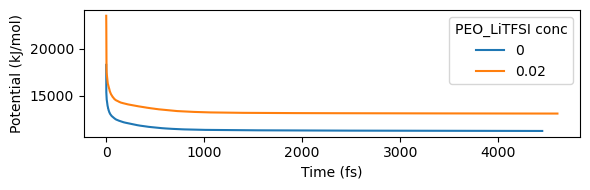

In [63]:
plt.figure(figsize=(3*2,2))
for conc in [0,0.02]:
    df=edrdf('em/em_'+str(conc)+'.edr')
    #plt.subplot(1,2,1)
    plt.plot(df['Time'],df['Potential'],label=str(conc))
    plt.xlabel('Time (fs)');plt.ylabel('Potential (kJ/mol)');
    #plt.subplot(1,2,2)
    #plt.plot(df['Time'],df['Pressure'],label=str(conc))
    #plt.xlabel('Time (fs)');plt.ylabel('Pressure (bar)');
    plt.legend(title='PEO_LiTFSI conc')
plt.tight_layout()

 ## Pre-equilibration step

In [ ]:
#%mkdir preeq
%cd preeq
%rm \#*
conc=0
#Initial NVT 
nvt_mdp=open('nvt.mdp','w+')
nvt_mdp.write('''title                   =  NVT pre-equilibration 

; Run parameters
integrator              = md        ; leap-frog integrator
nsteps                  = 1000000     ; 0.001 * 1000000 = 1000 ps (1ns)
dt                      = 0.001     ; 1 fs
; Output control
nstxout                 = 0       ; suppress bulky .trr filesave coordinates every 0 ps
nstvout                 = 0       ; save velocities every 0 ps
nstenergy               = 1000       ; save energies every 1 ps
nstlog                  = 1000       ; update log file every 1 ps
nstxout-compressed      = 100000      ; save compressed coordinates every 100.0 ps
compressed-x-grps       = System    ; save the whole system
; Bond parameters
continuation            = no        ; first dynamics run
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = h-bonds   ; bonds involving H are constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy
; Nonbonded settings 
cutoff-scheme           = Verlet    ; Buffered neighbor searching
ns_type                 = grid      ; search neighboring grid cells
nstlist                 = 10        ; 20 fs, largely irrelevant with Verlet
rcoulomb                = 1.2       ; short-range electrostatic cutoff (in nm)
rvdw                    = 1.2       ; short-range van der Waals cutoff (in nm)
DispCorr                = EnerPres  ; account for cut-off vdW scheme
; Electrostatics
coulombtype             = PME       ; Particle Mesh Ewald for long-range electrostatics
pme_order               = 4         ; cubic interpolation
fourierspacing          = 0.4      ; grid spacing for FFT
; Temperature coupling is on
tcoupl                  = V-rescale    ; modified Berendsen thermostat
tc-grps                 = System       ; two coupling groups - more accurate
tau_t                   = 1.0          ; time constant, in ps
ref_t                   = 400         ; reference temperature, one for each group, in K
; Pressure coupling is off
pcoupl                  = no        ; no pressure coupling in NVT
; Periodic boundary conditions
pbc                     = xyz       ; 3-D PBC
; Velocity generation
gen_vel                 = yes       ; assign velocities from Maxwell distribution
gen_temp                = 400       ; temperature for Maxwell distribution
gen_seed                = -1        ; generate a random seed
''')
nvt_mdp.close()

#!gmx grompp -f nvt.mdp -c ../em/em_{conc}.gro -p ../topol_{conc}.top -o nvt_{conc}.tpr -maxwarn 2
#!gmx mdrun -s nvt_{conc}.tpr -cpi nvt_{conc}.cpt -deffnm nvt_{conc} -v


%cd ..

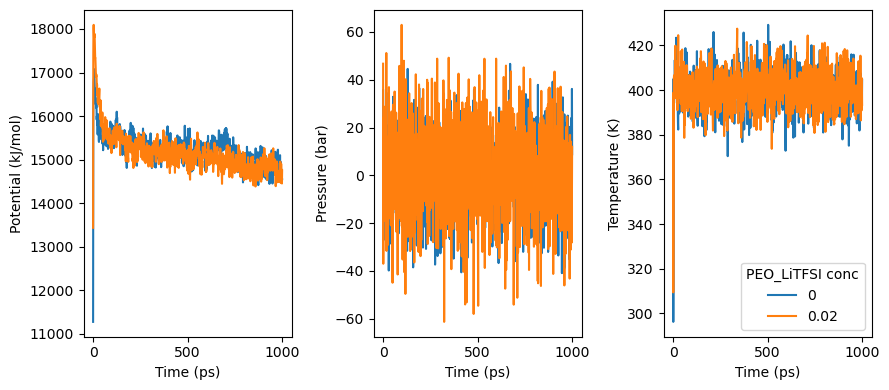

In [3]:
plt.figure(figsize=(3*3,4))
for conc in [0,0.02]:
    df=edrdf('preeq/nvt_'+str(conc)+'.edr')
    plt.subplot(1,3,1)
    plt.plot(df['Time'],df['Potential'],label=str(conc))
    plt.xlabel('Time (ps)');plt.ylabel('Potential (kJ/mol)');
    plt.subplot(1,3,2)
    plt.plot(df['Time'],df['Pressure'],label=str(conc))
    plt.xlabel('Time (ps)');plt.ylabel('Pressure (bar)');
    plt.subplot(1,3,3)
    plt.plot(df['Time'],df['Temperature'],label=str(conc))
    plt.xlabel('Time (ps)');plt.ylabel('Temperature (K)');
    plt.legend(title='PEO_LiTFSI conc')

plt.tight_layout()

In [4]:
vi=ngl.show_ase(read('preeq/nvt_0.02.gro'),viewer='ngl')
vi.add_unitcell()
vi.center()
vi.camera='orthographic'
vi

NGLWidget()

In [5]:
vi=ngl.show_ase(read('preeq/npt_0.02.gro'),viewer='ngl')
vi.add_unitcell()
vi.center()
vi.camera='orthographic'
vi

NGLWidget()

In [ ]:
%cd preeq
%rm \#* core
conc=0.02
#Initial NPT
npt_mdp=open('npt.mdp','w+')
npt_mdp.write('''title                   =  NPT pre-equilibration 

; Run parameters
integrator              = md        ; leap-frog integrator
nsteps                  = 10000000     ; 0.001 * 1000000 = 10000 ps (10ns)
dt                      = 0.001     ; 1 fs
; Output control
nstxout                 = 0       ; suppress bulky .trr filesave coordinates every 0 ps
nstvout                 = 0       ; save velocities every 1.0 ps
nstenergy               = 1000       ; save energies every 0.1 ps
nstlog                  = 1000       ; update log file every 0.1 ps
nstxout-compressed      = 100000      ; save compressed coordinates every 1.0 ps
;nstvout-compressed      = 1000      ; save compressed coordinates every 1.0 ps
compressed-x-grps       = System    ; save the whole system
; Bond parameters
continuation            = yes       ; Restarting after NVT 
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = h-bonds   ; bonds involving H are constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy
; Nonbonded settings 
cutoff-scheme           = Verlet    ; Buffered neighbor searching
ns_type                 = grid      ; search neighboring grid cells
nstlist                 = 10        ; 10 fs, largely irrelevant with Verlet scheme
rcoulomb                = 1.2       ; short-range electrostatic cutoff (in nm)
rvdw                    = 1.2       ; short-range van der Waals cutoff (in nm)
DispCorr                = EnerPres  ; account for cut-off vdW scheme
; Electrostatics
coulombtype             = PME       ; Particle Mesh Ewald for long-range electrostatics
pme_order               = 4         ; cubic interpolation
fourierspacing          = 0.4      ; grid spacing for FFT
; Temperature coupling is on
tcoupl                  = V-rescale             ; modified Berendsen thermostat
tc-grps                 = System        ; two coupling groups - more accurate
tau_t                   = 1.0         ; time constant, in ps
ref_t                   = 400        ; reference temperature, one for each group, in K
; Pressure coupling is on
pcoupl                  = Berendsen     ; Pressure coupling on in NPT
pcoupltype              = isotropic             ; uniform scaling of box vectors
tau_p                   = 1.0                   ; time constant, in ps
ref_p                   = 1.0                   ; reference pressure, in bar
compressibility         = 4.5e-5                ; isothermal compressibility of water, bar^-1
; Simulated annealing
annealing               = single
annealing_npoints        = 8
annealing_time          = 0 5000 5500 6000 6500 7000 7500 8000
annealing_temp          = 400 400 600 800 1000 800 600 400 
; Periodic boundary conditions
pbc                     = xyz       ; 3-D PBC
; Velocity generation
gen_vel                 = no        ; Velocity generation is off 

''')
npt_mdp.close()
!gmx editconf -f nvt_{conc}.gro -o nvt_small_{conc}.gro -c -d 0.2 -pbc
!gmx grompp -f npt.mdp -c nvt_small_{conc}.gro -p ../topol_{conc}.top -o npt_{conc}.tpr -maxwarn 2
#!gmx mdrun -s npt_{conc}.tpr -cpi npt_{conc}.cpt -deffnm npt_{conc} # -v
%cd ..

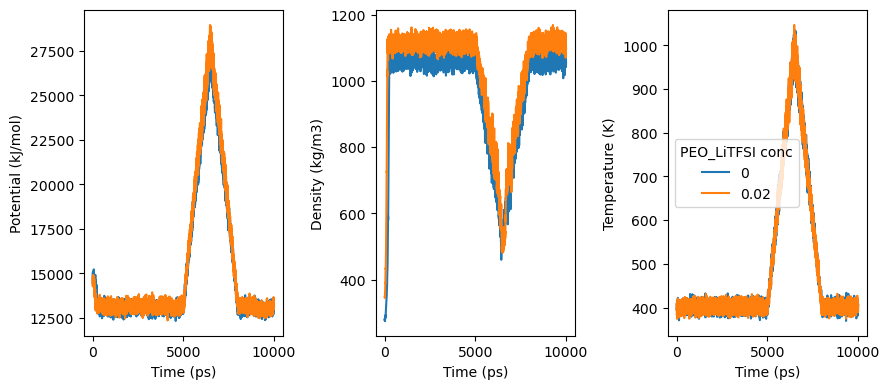

In [29]:
plt.figure(figsize=(3*3,4))
for conc in [0,0.02]:
    df=edrdf('preeq/npt_'+str(conc)+'.edr')
    plt.subplot(1,3,1)
    plt.plot(df['Time'],df['Potential'],label=str(conc))
    plt.xlabel('Time (ps)');plt.ylabel('Potential (kJ/mol)');
    plt.subplot(1,3,2)
    plt.plot(df['Time'],df['Density'],label=str(conc))
    plt.xlabel('Time (ps)');plt.ylabel('Density (kg/m3)');
    plt.subplot(1,3,3)
    plt.plot(df['Time'],df['Temperature'],label=str(conc))
    plt.xlabel('Time (ps)');plt.ylabel('Temperature (K)');
    plt.legend(title='PEO_LiTFSI conc')

plt.tight_layout()

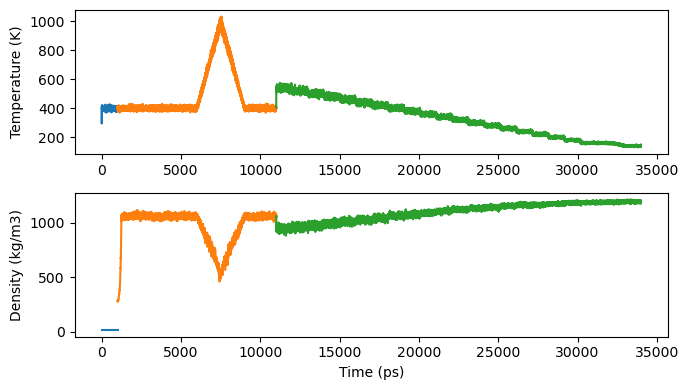

In [86]:
plt.figure(figsize=(7,4))
conc=0
df=edrdf('preeq/nvt_'+str(conc)+'.edr')
plt.subplot(2,1,1)
plt.plot(df['Time'],df['Temperature'],label=str(conc))
#plt.xlabel('Time (ps)');
plt.ylabel('Temperature (K)');
#plt.legend(title='PEO_LiTFSI conc')
plt.subplot(2,1,2)
vol_nm3=11.45580**3;mass=18786.80
df['density']=mass/vol_nm3
plt.plot(df['Time'],df['density'],label=str(conc))
plt.xlabel('Time (ps)');plt.ylabel('Density (kg/m3)');
t_nvt = df['Time'].iloc[-1]
df=edrdf('preeq/npt_'+str(conc)+'.edr')
plt.subplot(2,1,1)
plt.plot(t_nvt+df['Time'],df['Temperature'],label=str(conc))
plt.ylabel('Temperature (K)');
#plt.legend(title='PEO_LiTFSI conc')
plt.subplot(2,1,2)
plt.plot(t_nvt+df['Time'],df['Density'],label=str(conc))
plt.xlabel('Time (ps)');plt.ylabel('Density (kg/m3)');
t_npt = t_nvt+df['Time'].iloc[-1]
df=edrdf('Tg/npt_'+str(conc)+'.edr')
plt.subplot(2,1,1)
plt.plot(t_npt+df['Time'],df['Temperature'],label=str(conc))
plt.ylabel('Temperature (K)');
#plt.legend(title='PEO_LiTFSI conc')
plt.subplot(2,1,2)
plt.plot(t_npt+df['Time'],df['Density'],label=str(conc))
plt.xlabel('Time (ps)');plt.ylabel('Density (kg/m3)');
plt.tight_layout()

In [6]:
vi=ngl.show_ase(read('preeq/npt.gro'),viewer='ngl')
vi

NGLWidget()

## NPT Equilibiriation step

In [ ]:
%cd 400
%rm \#* core
conc=0.02
#Initial NPT
npt_mdp=open('npt.mdp','w+')
npt_mdp.write('''title                   =  NPT pre-equilibration 

; Run parameters
integrator              = md        ; leap-frog integrator
nsteps                  = 10000000     ; 0.001 * 1000000 = 10000 ps (10ns)
dt                      = 0.001     ; 1 fs
; Output control
nstxout                 = 0       ; suppress bulky .trr filesave coordinates every 0 ps
nstvout                 = 0       ; save velocities every 1.0 ps
nstenergy               = 1000       ; save energies every 0.1 ps
nstlog                  = 1000       ; update log file every 0.1 ps
nstxout-compressed      = 100000      ; save compressed coordinates every 1.0 ps
;nstvout-compressed      = 1000      ; save compressed coordinates every 1.0 ps
compressed-x-grps       = System    ; save the whole system
; Bond parameters
continuation            = yes       ; Restarting after NVT 
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = h-bonds   ; bonds involving H are constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy
; Nonbonded settings 
cutoff-scheme           = Verlet    ; Buffered neighbor searching
ns_type                 = grid      ; search neighboring grid cells
nstlist                 = 10        ; 10 fs, largely irrelevant with Verlet scheme
rcoulomb                = 1.2       ; short-range electrostatic cutoff (in nm)
rvdw                    = 1.2       ; short-range van der Waals cutoff (in nm)
DispCorr                = EnerPres  ; account for cut-off vdW scheme
; Electrostatics
coulombtype             = PME       ; Particle Mesh Ewald for long-range electrostatics
pme_order               = 4         ; cubic interpolation
fourierspacing          = 0.4      ; grid spacing for FFT
; Temperature coupling is on
tcoupl                  = V-rescale             ; modified Berendsen thermostat
tc-grps                 = System        ; two coupling groups - more accurate
tau_t                   = 1.0         ; time constant, in ps
ref_t                   = 400        ; reference temperature, one for each group, in K
; Pressure coupling is on
pcoupl                  = Berendsen     ; Pressure coupling on in NPT
pcoupltype              = isotropic             ; uniform scaling of box vectors
tau_p                   = 1.0                   ; time constant, in ps
ref_p                   = 1.0                   ; reference pressure, in bar
compressibility         = 4.5e-5                ; isothermal compressibility of water, bar^-1
; Periodic boundary conditions
pbc                     = xyz       ; 3-D PBC
; Velocity generation
gen_vel                 = no        ; Velocity generation is off 

''')
npt_mdp.close()

#!gmx grompp -f npt.mdp -c ../preeq/npt_{conc}.gro -p ../topol_{conc}.top -o npt_{conc}.tpr -maxwarn 2
#!gmx mdrun -s npt_{conc}.tpr -cpi npt_{conc}.cpt -deffnm npt_{conc} # -v
%cd ..

In [7]:
vi=ngl.show_ase(read('400/npt_eq.gro'),viewer='ngl')
vi

NGLWidget()